In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from time import time

import pyro
import torch
import pyro.optim as optim
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO, Predictive, MCMC, NUTS
from pyro.distributions import constraints
from pyro.contrib.autoguide import AutoDiagonalNormal
from sklearn.preprocessing import StandardScaler

pyro.enable_validation(True)

# Questions for Gurpreet
- We can use observed dummy/categorical variables, correct?
- Seems our data might fit a Zero-inflated poisson better, but how should we interpret/should we predict the gate, too (e.g. with a logit/probit)?
- Should a log link function on a poisson regression approximate a pareto distribution?

# Complete Level Model
Here, we will model each post as coming from one of four types, one subreddit, and being about one story.

# Data

First, we load the Reddit datasets

In [4]:
comments = dict()
with open('../data/results/Comments.json') as f:
    for line in f:
        post = json.loads(line)
        comments[post['pid']] = post['api_num_comments'], post['comments']

In [5]:
corrections = []
with open('../data/results/CorrectionPairs.json') as f:
    for line in f:
        corrections.append(json.loads(line))

In [6]:
news = []
with open('../data/results/NewsPairs.json') as f:
    for line in f:
        news.append(json.loads(line))

In [7]:
([n for n in news if len(n['r']['countries']) == 21])

[{'r': {'uid': 'b123ebd6-b1ce-264c-652b-e709ecb7d5e6',
   'claimDate': '2019-07-22T00:00:00.000Z',
   'reviewDate': '2019-07-22T00:00:00.000Z',
   'reviewUrl': 'https://www.polygraph.info/a/fact-check-russian-black-sea-presence-becoming-physically-disruptive/30065465.html',
   'claimReviewed': '“The Ukrainian Navy’s claims that the Black Sea Fleet’s Smetlivy patrol vessel entered the closed area of the Sea Breeze 2019 exercise are untrue.”',
   'countries': ['gr',
    'ru',
    'dk',
    'no',
    'tr',
    'fr',
    'ge',
    'lv',
    'it',
    'lt',
    'gb',
    'ee',
    'md',
    'pl',
    'us',
    'tw',
    'ua',
    'ca',
    'sy',
    'se',
    'bg'],
   'claimReviewed_en': None,
   'reviewAuthor': {'name': 'POLYGRAPH.info', 'authorURL': 'polygraph.info'},
   'reviewRating': {'ratingValue': 1,
    'worstRating': 1,
    'bestRating': 5,
    'alternateName': 'Likely False',
    'isFakeClaim': True,
    'isFakeStory': True},
   'claimAuthor': {'name': "Russia's Black Sea Fleet",

In [8]:
news[0]

{'r': {'uid': 'b123ebd6-b1ce-264c-652b-e709ecb65d2f',
  'claimDate': '2017-10-02T00:00:00.000Z',
  'reviewDate': '2017-10-05T17:40:10.000Z',
  'reviewUrl': 'http://www.politifact.com/truth-o-meter/statements/2017/oct/05/steve-israel/former-democratic-congressman-compares-gun-violenc/',
  'claimReviewed': 'Says the Dickey Amendment "prevents the Centers for Disease Control and Prevention from even researching the relationship between gun violence and public health. ... The government can’t study gun violence but is spending $400,000 analyzing the effects of Swedish massages on rabbits."',
  'countries': ['us'],
  'claimReviewed_en': None,
  'reviewAuthor': {'name': 'PolitiFact', 'authorURL': 'politifact.com'},
  'reviewRating': {'ratingValue': 5,
   'worstRating': 1,
   'bestRating': 7,
   'alternateName': 'Mostly True',
   'isFakeClaim': False,
   'isFakeStory': False},
  'claimAuthor': {'name': 'Steve Israel',
   'claimURL': 'https://www.nytimes.com/2017/10/02/opinion/gun-control-vega

In [9]:
len({n['p']['subreddit'] for n in (corrections + news)})

1333

Gather relevant variables

In [10]:
def processData(items, comments, minutes=60):
    
    # story level
    sids = list(sorted({n['r']['uid'] for n in items}))
    sid_indices = {sid: i for i, sid in enumerate(sids)}
    
    countries = list(sorted({c for n in items for c in n['r']['countries']}))
    country_indices = {country: i for i, country in enumerate(countries)}
    
    authors = list(sorted({n['r']['reviewAuthor']['authorURL'] for n in items}))
    author_indices = {author: i for i, author in enumerate(authors)}
    
    story_claim_titles = [""] * len(sids)
    
    s_data = np.zeros((len(sids), 1 + len(countries) + len(authors)))
    # bias.
    s_data[:,0] = 1
    
    # subreddit level
    subreddits = list(sorted({n['p']['subreddit'] for n in items}))
    subreddit_indices = {subreddit: i for i, subreddit in enumerate(subreddits)}
    
    r_data = np.concatenate([np.ones((len(subreddits),1)), np.eye(len(subreddits))], axis=1)
    
    # type level
    # This t_data is just encoding each with its own dummy (with bias terms)
    t_data = np.array([[1, 1, 0, 0, 0],
                       [1, 0, 1, 0, 0],
                       [1, 0, 0, 1, 0],
                       [1, 0, 0, 0, 1]])
    
    
    # post level
    p_stories = np.empty((len(items),))
    p_subreddits = np.empty((len(items),))
    p_types = np.empty((len(items),))
    y = np.empty((len(items),))
    
    num_p_indep = 7
    p_data = np.zeros((len(items), num_p_indep))
    
    # set bias
    p_data[:,0] = 1
    
    for i, n in enumerate(items):
        
        # post-level
        isNews = 'isFakeStory' in n['r']['reviewRating']
        news_id = n['p']['id']
        
        # story-level
        story_id = n['r']['uid']
        
        claim_title = n['r']['claimReviewed']
        p_countries = n['r']['countries']
        review_author = n['r']['reviewAuthor']['authorURL']
        
        p_stories[i] = sid_indices[story_id]
        
        for c in p_countries:
            s_data[sid_indices[story_id], 1 + country_indices[c]] = 1
            
        s_data[sid_indices[story_id], 1 + len(countries) + author_indices[review_author]] = 1
        
        story_claim_titles[sid_indices[story_id]] = claim_title
        
        # subreddit-level
        subreddit = n['p']['subreddit']
        p_subreddits[i] = subreddit_indices[subreddit]
        
        num_cmts, cmts = comments[news_id]
        c_body_lens = []
        c_ups = []
        c_downs = []
        unique_authors = set()
        for c in cmts:
            # skip if comment not created in first _ mins
            if c['delta_seconds'] > minutes * 60:
                continue

            c_minutes = c['delta_seconds'] / 60
            if c_minutes <= minutes:   # cmts in first _ mins
                p_data[i, 6] += 1
            
            c_body_lens.append(c['body_len'])
            c_ups.append(c['ups'])
            c_downs.append(c['downs'])
            
            if c['author']:
                unique_authors.add(c['author'])
        
        if isNews:
            p_types[i] = 1 if n['r']['reviewRating']['isFakeStory'] else 0
        else:
            p_types[i] = 3 if n['r']['reviewRating']['isFakeClaim'] else 2
            
        y[i] = num_cmts
        p_data[i, 1] = np.mean(c_body_lens) if c_body_lens else 0.
        p_data[i, 2] = np.std(c_body_lens) if c_body_lens else 0.
        p_data[i, 3] = np.mean(c_ups) if c_ups else 0.
        p_data[i, 4] = np.std(c_ups) if c_ups else 0.
        p_data[i, 5] = len(unique_authors) if unique_authors else 0.
    
    # Adjust p_data
    
    # normalize avg net upvotes by std net upvotes:
    # TODO should we do this +1?
    p_data[:,3] = p_data[:, 3] / (p_data[:, 4] + 1)
    
    # select relevant indep vars
    p_data = p_data[:, (0,1,3,5,6)]  # bias, avg cmt length, avg net upvotes, num authors, num initial comments
        
    
    data_tuple = (p_data, t_data, s_data, r_data, y)
    lookup_tuple = (p_types, p_stories, p_subreddits)
    label_tuple = (countries, authors, story_claim_titles, subreddits)
        
    return data_tuple, lookup_tuple, label_tuple

### Process and Unpack Data

In [11]:
data_tuple, lookup_tuple, label_tuple = processData(news + corrections, comments)

In [12]:
p_data, t_data, s_data, r_data, y = data_tuple
p_types, p_stories, p_subreddits = lookup_tuple
countries, authors, story_claim_titles, subreddits = label_tuple

p_data variables (in order):

0. bias
1. comment_length_avg
2. normalized comment_upvotes_avg
3. num_unique_comment_authors
4. num_comments in first _ mins

types

0. Real News
1. Fake News
2. Correction on Real News
3. Correction on Fake News

t_data variables (in order):

0. bias
1. Real News Dummy
2. Fake News Dummy
3. Correction on Real News Dummy
4. Correction on Fake News Dummy

s_data variables:

0. bias
1. country dummies (multiple may be "on")
2. author dummies

r_data variables:

0. bias
1. subreddit dummies

### Data Transformations

In [13]:
# before we change anything, save the original p_data
original_p_data = p_data.copy()

#### log some data.

In [14]:
# num initial comments
p_data[:,4] = np.log(p_data[:,4] + 1)

# avg upvotes
#p_data[:,2] = np.log(p_data[:,2] + 1)

# num authors
p_data[:,3] = np.log(p_data[:,3] + 1)

# avg comment len
p_data[:,1] = np.log(p_data[:,1] + 1)

In [15]:
# scale our data.
scaler = StandardScaler()
p_data[:,[1,2,3,4]] = scaler.fit_transform(p_data[:,[1,2,3,4]])
#p_data[:,[1]] = scaler.fit_transform(p_data[:,[1]])

split into train/test

In [16]:
train_frac = 0.7
num_obs = p_data.shape[0]
idx = np.random.binomial(1, train_frac, size=num_obs).astype(bool)

p_data_train = p_data[idx,:]
p_data_test = p_data[~idx,:]

p_types_train = p_types[idx]
p_types_test = p_types[~idx]

p_stories_train = p_stories[idx]
p_stories_test = p_stories[~idx]

p_subreddits_train = p_subreddits[idx]
p_subreddits_test = p_subreddits[~idx]

y_train = y[idx]
y_test = y[~idx]

-----

# Modeling

Cast data to torch tensors

In [17]:
# data
p_data_train = torch.Tensor(p_data_train).double()
p_data_test = torch.Tensor(p_data_test).double()
t_data = torch.Tensor(t_data).double()
s_data = torch.Tensor(s_data).double()
r_data = torch.Tensor(r_data).double()

y_train = torch.Tensor(y_train).double()
y_test = torch.Tensor(y_test).double()

# types
p_types_train = torch.Tensor(p_types_train).long()
p_types_test = torch.Tensor(p_types_test).long()
p_stories_train = torch.Tensor(p_stories_train).long()
p_stories_test = torch.Tensor(p_stories_test).long()
p_subreddits_train = torch.Tensor(p_subreddits_train).long()
p_subreddits_test = torch.Tensor(p_subreddits_test).long()

2 Regressions.

Post-Level Regression

y_pt = phi_0,t * bias + phi_1,t * first_hour_comments + epsilon_pt

Type-Level Regressions (2)

phi_0t = eta_00 * bias + eta_01 silliness_t + nu_0t

phi_1t = eta_10 * bias + eta_11 silliness_t + nu_1t

In [19]:
def model(p_data, t_data, s_data, r_data, y, p_types, p_stories, p_subreddits):
    num_posts, num_p_indeps = p_data.shape
    num_types, num_t_indeps = t_data.shape
    num_stories, num_s_indeps = s_data.shape
    num_subreddits, num_r_indeps = r_data.shape
    
    # define a prior for our regression variables
    
    # Type Level
    alpha_loc = torch.zeros((num_p_indeps, num_t_indeps), dtype=torch.float64)
    alpha_scale = 2. * torch.ones((num_p_indeps, num_t_indeps), dtype=torch.float64)

    with pyro.plate("t_indep", num_t_indeps, dim=-1) as ti:
        with pyro.plate("p_indep1", num_p_indeps, dim=-2) as pi:
            eta = pyro.sample("eta", dist.Normal(alpha_loc, alpha_scale))
    
    with pyro.plate("type", num_types, dim=-1) as t:
        with pyro.plate("p_indep2", num_p_indeps, dim=-2) as pi:
            phi_loc = torch.matmul(eta, t_data[t,:].T) # (num_p_indeps, num_t_indeps) x (num_t_indeps, num_types)

            phi_dist = dist.Normal(phi_loc, 2.)
            phi = pyro.sample("phi", phi_dist)
            
    # Story Level
    beta_loc = torch.zeros((num_p_indeps, num_s_indeps), dtype=torch.float64)
    beta_scale = 1. * torch.ones((num_p_indeps, num_s_indeps), dtype=torch.float64)

    with pyro.plate("s_indep", num_s_indeps, dim=-1) as si:
        with pyro.plate("p_indep3", num_p_indeps, dim=-2) as pi:
            beta = pyro.sample("beta", dist.Normal(beta_loc, beta_scale))
    
    with pyro.plate("story", num_stories, dim=-1) as s:
        with pyro.plate("p_indep4", num_p_indeps, dim=-2) as pi:
            theta_loc = torch.matmul(beta, s_data[s,:].T) # (num_p_indeps, num_s_indeps) x (num_s_indeps, num_stories)

            theta_dist = dist.Normal(theta_loc, 1.)
            theta = pyro.sample("theta", theta_dist)
    
    # Subreddit Level
    tau_loc = torch.zeros((num_p_indeps, num_r_indeps), dtype=torch.float64)
    tau_scale = 1. * torch.ones((num_p_indeps, num_r_indeps), dtype=torch.float64)

    with pyro.plate("r_indep", num_r_indeps, dim=-1) as ri:
        with pyro.plate("p_indep5", num_p_indeps, dim=-2) as pi:
            tau = pyro.sample("tau", dist.Normal(tau_loc, tau_scale))
    
    with pyro.plate("subreddit", num_subreddits, dim=-1) as r:
        with pyro.plate("p_indep6", num_p_indeps, dim=-2) as pi:
            rho_loc = torch.matmul(tau, r_data[r,:].T) # (num_p_indeps, num_r_indeps) x (num_r_indeps, num_subreddits)

            rho_dist = dist.Normal(rho_loc, 1.)
            rho = pyro.sample("rho", rho_dist)
    
    # for each post, use the correct set of coefficients to run our post-level regression
    with pyro.plate("post", num_posts, dim=-1) as p:    
        t = p_types[p]
        s = p_stories[p]
        r = p_subreddits[p]

        # indep vars for this post
        indeps = p_data[p,:]
        
        t_coefs = phi[:,t] # (num_p_indeps,num_posts)
        s_coefs = theta[:,s] # (num_p_indeps,num_posts)
        r_coefs = rho[:,r] # (num_p_indeps,num_posts)
        
        type_level_products = torch.mul(t_coefs, indeps.T) # (num_p_indeps, num_posts) .* (num_p_indeps, num_posts)
        story_level_products = torch.mul(s_coefs, indeps.T) # (num_p_indeps, num_posts) .* (num_p_indeps, num_posts)
        subreddit_level_products = torch.mul(r_coefs, indeps.T) # (num_p_indeps, num_posts) .* (num_p_indeps, num_posts)

        # calculate the mean: desired shape (num_posts, 1)
        mu = (subreddit_level_products + type_level_products + story_level_products).sum(dim=0)  # (num_p_indeps, num_posts).sum(over indeps)
        
        # sample
        if y is None:
            pyro.sample("obs", dist.Poisson(rate=torch.exp(mu)), obs=y)
        else:
            pyro.sample("obs", dist.Poisson(rate=torch.exp(mu)), obs=y[p])


In [20]:
def guide(p_data, t_data, s_data, r_data, y, p_types, p_stories, p_subreddits):
    num_posts, num_p_indeps = p_data.shape
    num_types, num_t_indeps = t_data.shape
    num_stories, num_s_indeps = s_data.shape
    num_subreddits, num_r_indeps = r_data.shape
    
    # define a prior for our regression variables
    
    # type level
    alpha_loc = torch.zeros((num_p_indeps, num_t_indeps), dtype=torch.float64)
    alpha_scale = 2. * torch.ones((num_p_indeps, num_t_indeps), dtype=torch.float64)
    
    # The zeros and ones are the "alpha" in the graphical model from the proposal
    eta_loc = pyro.param("eta_loc", 
                         alpha_loc)
    eta_scale = pyro.param("eta_scale", 
                           alpha_scale, 
                           constraint=constraints.positive)
            
    with pyro.plate("t_indep", num_t_indeps, dim=-1) as ti:
        with pyro.plate("p_indep1", num_p_indeps, dim=-2) as pi:
            eta = pyro.sample("eta", dist.Normal(eta_loc, eta_scale))
    
    phi_scale = pyro.param("phi_scale", 
                           2. * torch.ones((num_p_indeps, 1), dtype=torch.float64), 
                           constraint=constraints.positive) # share among all types.
    
    with pyro.plate("type", num_types, dim=-1) as t:
        with pyro.plate("p_indep2", num_p_indeps, dim=-2) as pi:
            phi_loc = torch.matmul(eta, t_data[t,:].T) # (num_p_indeps, num_t_indeps) x (num_t_indeps, num_types)

            phi = pyro.sample("phi", dist.Normal(phi_loc, phi_scale))
            
    # story level
    beta_loc = pyro.param("beta_loc", 
                          torch.zeros((num_p_indeps, num_s_indeps), dtype=torch.float64))
    beta_scale = pyro.param("beta_scale", 
                            1. * torch.ones((num_p_indeps, num_s_indeps), dtype=torch.float64), 
                            constraint=constraints.positive)

    with pyro.plate("s_indep", num_s_indeps, dim=-1) as si:
        with pyro.plate("p_indep3", num_p_indeps, dim=-2) as pi:
            beta = pyro.sample("beta", dist.Normal(beta_loc, beta_scale))
            
    theta_scale = pyro.param("theta_scale", 
                           1. * torch.ones((num_p_indeps, 1), dtype=torch.float64), 
                           constraint=constraints.positive) # share among all types.
    
    with pyro.plate("story", num_stories, dim=-1) as s:
        with pyro.plate("p_indep4", num_p_indeps, dim=-2) as pi:
            theta_loc = torch.matmul(beta, s_data[s,:].T) # (num_p_indeps, num_s_indeps) x (num_s_indeps, num_stories)

            theta = pyro.sample("theta", dist.Normal(theta_loc, theta_scale))
    
    # subreddit level
    tau_loc = pyro.param("tau_loc", 
                          torch.zeros((num_p_indeps, num_r_indeps), dtype=torch.float64))
    tau_scale = pyro.param("tau_scale", 
                            1. * torch.ones((num_p_indeps, num_r_indeps), dtype=torch.float64), 
                            constraint=constraints.positive)

    with pyro.plate("r_indep", num_r_indeps, dim=-1) as ri:
        with pyro.plate("p_indep5", num_p_indeps, dim=-2) as pi:
            tau = pyro.sample("tau", dist.Normal(tau_loc, tau_scale))
            
    rho_scale = pyro.param("rho_scale", 
                           1. * torch.ones((num_p_indeps, 1), dtype=torch.float64), 
                           constraint=constraints.positive) # share among all types.
    
    with pyro.plate("subreddit", num_subreddits, dim=-1) as r:
        with pyro.plate("p_indep6", num_p_indeps, dim=-2) as pi:
            rho_loc = torch.matmul(tau, r_data[r,:].T) # (num_p_indeps, num_r_indeps) x (num_r_indeps, num_subreddits)

            rho = pyro.sample("rho", dist.Normal(rho_loc, rho_scale))
    
    
    return eta, phi, beta, theta

In [21]:
pyro.clear_param_store()

## Traces (to double check tensor shapes)

# Inference

## SVI

In [22]:
SUBSAMPLE = False

svi = SVI(model,
          guide,
          optim.ClippedAdam({"lr": 1e-2}),
          loss=JitTrace_ELBO())

pyro.clear_param_store()
num_iters = 10000
losses = np.zeros((num_iters,))

start_time = time()

for i in range(num_iters):
    if SUBSAMPLE:
        elbo = svi.step(p_data_train[:250], 
                        t_data, 
                        s_data, 
                        r_data, 
                        y_train[:250], 
                        p_types_train[:250], 
                        p_stories_train[:250], 
                        p_subreddits_train[:250])
    else:
        elbo = svi.step(p_data_train, 
                        t_data, 
                        s_data, 
                        r_data, 
                        y_train, 
                        p_types_train, 
                        p_stories_train, 
                        p_subreddits_train)
    losses[i] = elbo
    if i % 100 == 99:
        elapsed = time() - start_time
        remaining = (elapsed / (i+1)) * (num_iters - i)
        print(f"Iter {i+1}/{num_iters}"
              "\t||\t"
              f"Elbo loss: {elbo:.2e}"
              "\t||\t"
              f"Time Elapsed: {int(elapsed) // 60:02}:{int(elapsed) % 60:02}"
              "\t||\t"
              f"Est Remaining: {int(remaining) // 60:02}:{int(remaining) % 60:02}", end="\r", flush=True)

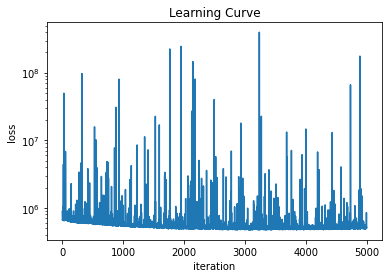

In [26]:
plt.plot(range(len(losses[5000:])), np.array(losses[5000:]))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.yscale("log")
plt.title("Learning Curve")
plt.show()

----

In [27]:
import pyro.poutine as poutine

In [28]:
trace = poutine.trace(model).get_trace(p_data_train, 
                                       t_data, 
                                       s_data, 
                                       r_data, 
                                       y_train, 
                                       p_types_train, 
                                       p_stories_train,
                                       p_subreddits_train,
                                      )
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

 Trace Shapes:          
  Param Sites:          
 Sample Sites:          
  t_indep dist         |
         value       5 |
      log_prob         |
 p_indep1 dist         |
         value       5 |
      log_prob         |
      eta dist 5     5 |
         value 5     5 |
      log_prob 5     5 |
     type dist         |
         value       4 |
      log_prob         |
 p_indep2 dist         |
         value       5 |
      log_prob         |
      phi dist 5     4 |
         value 5     4 |
      log_prob 5     4 |
  s_indep dist         |
         value      54 |
      log_prob         |
 p_indep3 dist         |
         value       5 |
      log_prob         |
     beta dist 5    54 |
         value 5    54 |
      log_prob 5    54 |
    story dist         |
         value    7763 |
      log_prob         |
 p_indep4 dist         |
         value       5 |
      log_prob         |
    theta dist 5  7763 |
         value 5  7763 |
      log_prob 5  7763 |
  r_indep dist         |


In [29]:
trace = poutine.trace(guide).get_trace(p_data_train, 
                                       t_data, 
                                       s_data, 
                                       r_data, 
                                       y_train, 
                                       p_types_train, 
                                       p_stories_train,
                                       p_subreddits_train,
                                      )
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

 Trace Shapes:            
  Param Sites:            
       eta_loc      5    5
     eta_scale      5    5
     phi_scale      5    1
      beta_loc      5   54
    beta_scale      5   54
   theta_scale      5    1
       tau_loc      5 1334
     tau_scale      5 1334
     rho_scale      5    1
 Sample Sites:            
  t_indep dist           |
         value      5    |
      log_prob           |
 p_indep1 dist           |
         value      5    |
      log_prob           |
      eta dist 5    5    |
         value 5    5    |
      log_prob 5    5    |
     type dist           |
         value      4    |
      log_prob           |
 p_indep2 dist           |
         value      5    |
      log_prob           |
      phi dist 5    4    |
         value 5    4    |
      log_prob 5    4    |
  s_indep dist           |
         value     54    |
      log_prob           |
 p_indep3 dist           |
         value      5    |
      log_prob           |
     beta dist 5   54    |
 

## MCMC (NUTS)

In [30]:
#kernel = NUTS(model_no_subsample)

#num_iters = 1000
#warmup_steps = 500
#mcmc = MCMC(kernel, num_samples=num_iters, warmup_steps=warmup_steps)
#mcmc.run(p_data_train[:100], p_types_train[:100], t_data, y_train[:100])

In [31]:
#posterior_samples = mcmc.get_samples()

In [32]:
#eta_means = posterior_samples["eta"].mean(dim=0)
#eta_means

In [33]:
#phi_means = posterior_samples["phi"].mean(dim=0)
#phi_means

# Evaluation

Recall:

Variables (in order):

0. num_comments
1. type
2. comment_length_avg
3. comment_length_std
4. comment_upvotes_avg
5. comment_upvotes_std
6. num_unique_comment_authors
7. num_comments in first _ mins

types

0. Real News
1. Fake News
2. Correction on Real News
3. Correction on Fake News

t level Variables (in order):

0. Is Review? (vs. news)
1. Is about fake story? (Not included yet)

Check the fit

2 Regressions.

Post-Level Regression

y_pt = phi_0,t * bias + phi_1,t * first_hour_comments + epsilon_pt

Type-Level Regressions (2)

phi_0t = eta_00 * bias + nu_0t

phi_1t = eta_10 * bias + nu_1t

In [34]:
labels = np.array(["Factual News", "Fake News", "Review of Factual News", "Review of Fake News"])

<ipython-input-35-25465b7dd52a>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_coefs = torch.tensor(phi[:,t]) # (num_p_indeps,num_posts)
<ipython-input-35-25465b7dd52a>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_coefs = torch.tensor(theta[:,s]) # (num_p_indeps,num_posts)
<ipython-input-35-25465b7dd52a>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_coefs = torch.tensor(rho[:,r]) # (num_p_indeps,num_posts)


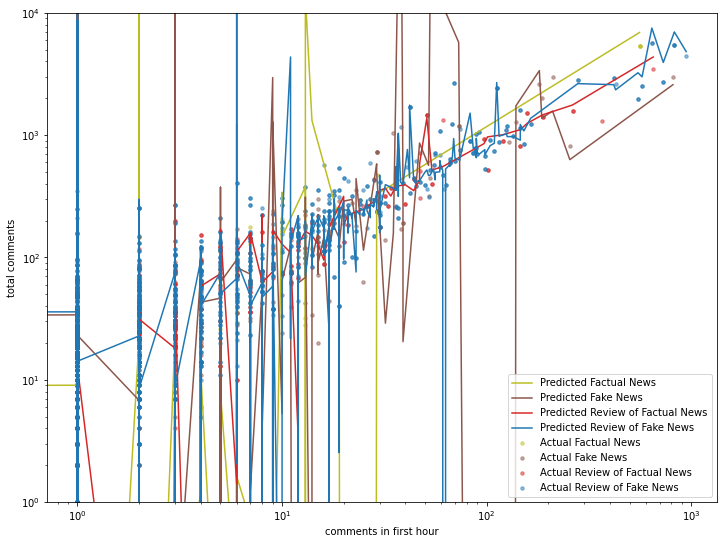

In [35]:
indep = 4

indep_dict = {
    1: "avg cmt length",
    2: "avg upvotes",
    3: "num authors",
    4: "comments in first hour",
}
# indep_dict = {
#     1: "comments in first hour",
# }

use_MCMC = False

if use_MCMC:
    eta_loc = eta_means
    beta_loc = beta_means
    tau_loc = gamma_means
else:
    eta_loc = pyro.param('eta_loc').detach()
    beta_loc = pyro.param('beta_loc').detach()
    tau_loc = pyro.param('tau_loc').detach()

phi = torch.matmul(eta_loc, t_data.T)
theta = torch.matmul(beta_loc, s_data.T)
rho = torch.matmul(tau_loc, r_data.T)

t = torch.Tensor(p_types).long()
s = torch.Tensor(p_stories).long()
r = torch.Tensor(p_subreddits).long()

indeps = torch.tensor(p_data)

t_coefs = torch.tensor(phi[:,t]) # (num_p_indeps,num_posts)
s_coefs = torch.tensor(theta[:,s]) # (num_p_indeps,num_posts)
r_coefs = torch.tensor(rho[:,r]) # (num_p_indeps,num_posts)

mu = (torch.mul(t_coefs, indeps.T) 
      + torch.mul(s_coefs, indeps.T) 
      + torch.mul(r_coefs, indeps.T)
     ).sum(dim=0)

y_pred = np.exp(mu)


plt.figure(figsize=(12,9))

types = np.unique(p_types)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
color_choices = np.random.choice(colors, size=len(types), replace=False)



for i, t in enumerate(types):
#     if t == 0:
        y_pred_t = y_pred[p_types == t]
        y_t = 1 * y[p_types == t]
        x_t = original_p_data[p_types == t,indep]
        
        sorted_indices = np.argsort(x_t)

        type_label = labels[int(t)]

        color = color_choices[i]
        plt.scatter(x_t, y_t, alpha=0.5, s=12, c=color, label=f"Actual {type_label}")
        plt.plot(x_t[sorted_indices], y_pred_t[sorted_indices], c=color, label=f"Predicted {type_label}")
    
# plt.plot(np.array(p_data[:,indep]), np.array(y_pred_mcmc), c='tab:green', label=f'MCMC: {phi_means[0]}, {phi_means[1]}') # MCMC
plt.xlabel(indep_dict[indep])
plt.ylabel('total comments')

plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylim(1,1e4)
# plt.xlim(0,10)
plt.show()

Interpretation:

- For posts with no comments in the first hour, we expect 7.23 comments in total
- For every comment in the first hour, we expect an additional 6.43 comments in total

----

Generate posterior predictive samples

In [36]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape((1,num_samples,-1)).detach().cpu().numpy()
               for k, v in predictive(p_data_train, 
                                      t_data, 
                                      s_data, 
                                      r_data, 
                                      None, 
                                      p_types_train, 
                                      p_stories_train,
                                      p_subreddits_train,
                                     ).items()}

In [37]:
svi_az = az.convert_to_inference_data({'obs': svi_samples['obs']}, group='posterior_predictive')

In [38]:
svi_az.add_groups({'posterior': {'phi': svi_samples['phi'], 
                                 'eta': svi_samples['eta'], 
                                 'theta': svi_samples['theta'], 
                                 'beta': svi_samples['beta'],
                                 'tau': svi_samples['tau'],
                                 'rho': svi_samples['rho']}})

In [39]:
svi_az.add_groups({'observed_data': {'obs': y_train.reshape(1,1,-1)}})

/Users/marcusdaly/Documents/Grad/Y1S1/MLWithProbProg/Probabilistic-Programming/venv/lib/python3.8/site-packages/arviz/data/inference_data.py:790: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


---

Posterior distribution over latent variables:

In [24]:
# az.plot_trace(svi_az, compact=True)
# plt.show()

In [84]:
az.plot_trace(svi_az.posterior['phi'], compact=False)
plt.show()

KeyboardInterrupt: 

/Users/marcusdaly/Documents/Grad/Y1S1/MLWithProbProg/Probabilistic-Programming/venv/lib/python3.8/site-packages/arviz/plots/plot_utils.py:477: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (46) in plot_posterior, generating only 40 plots
  warnings.warn(


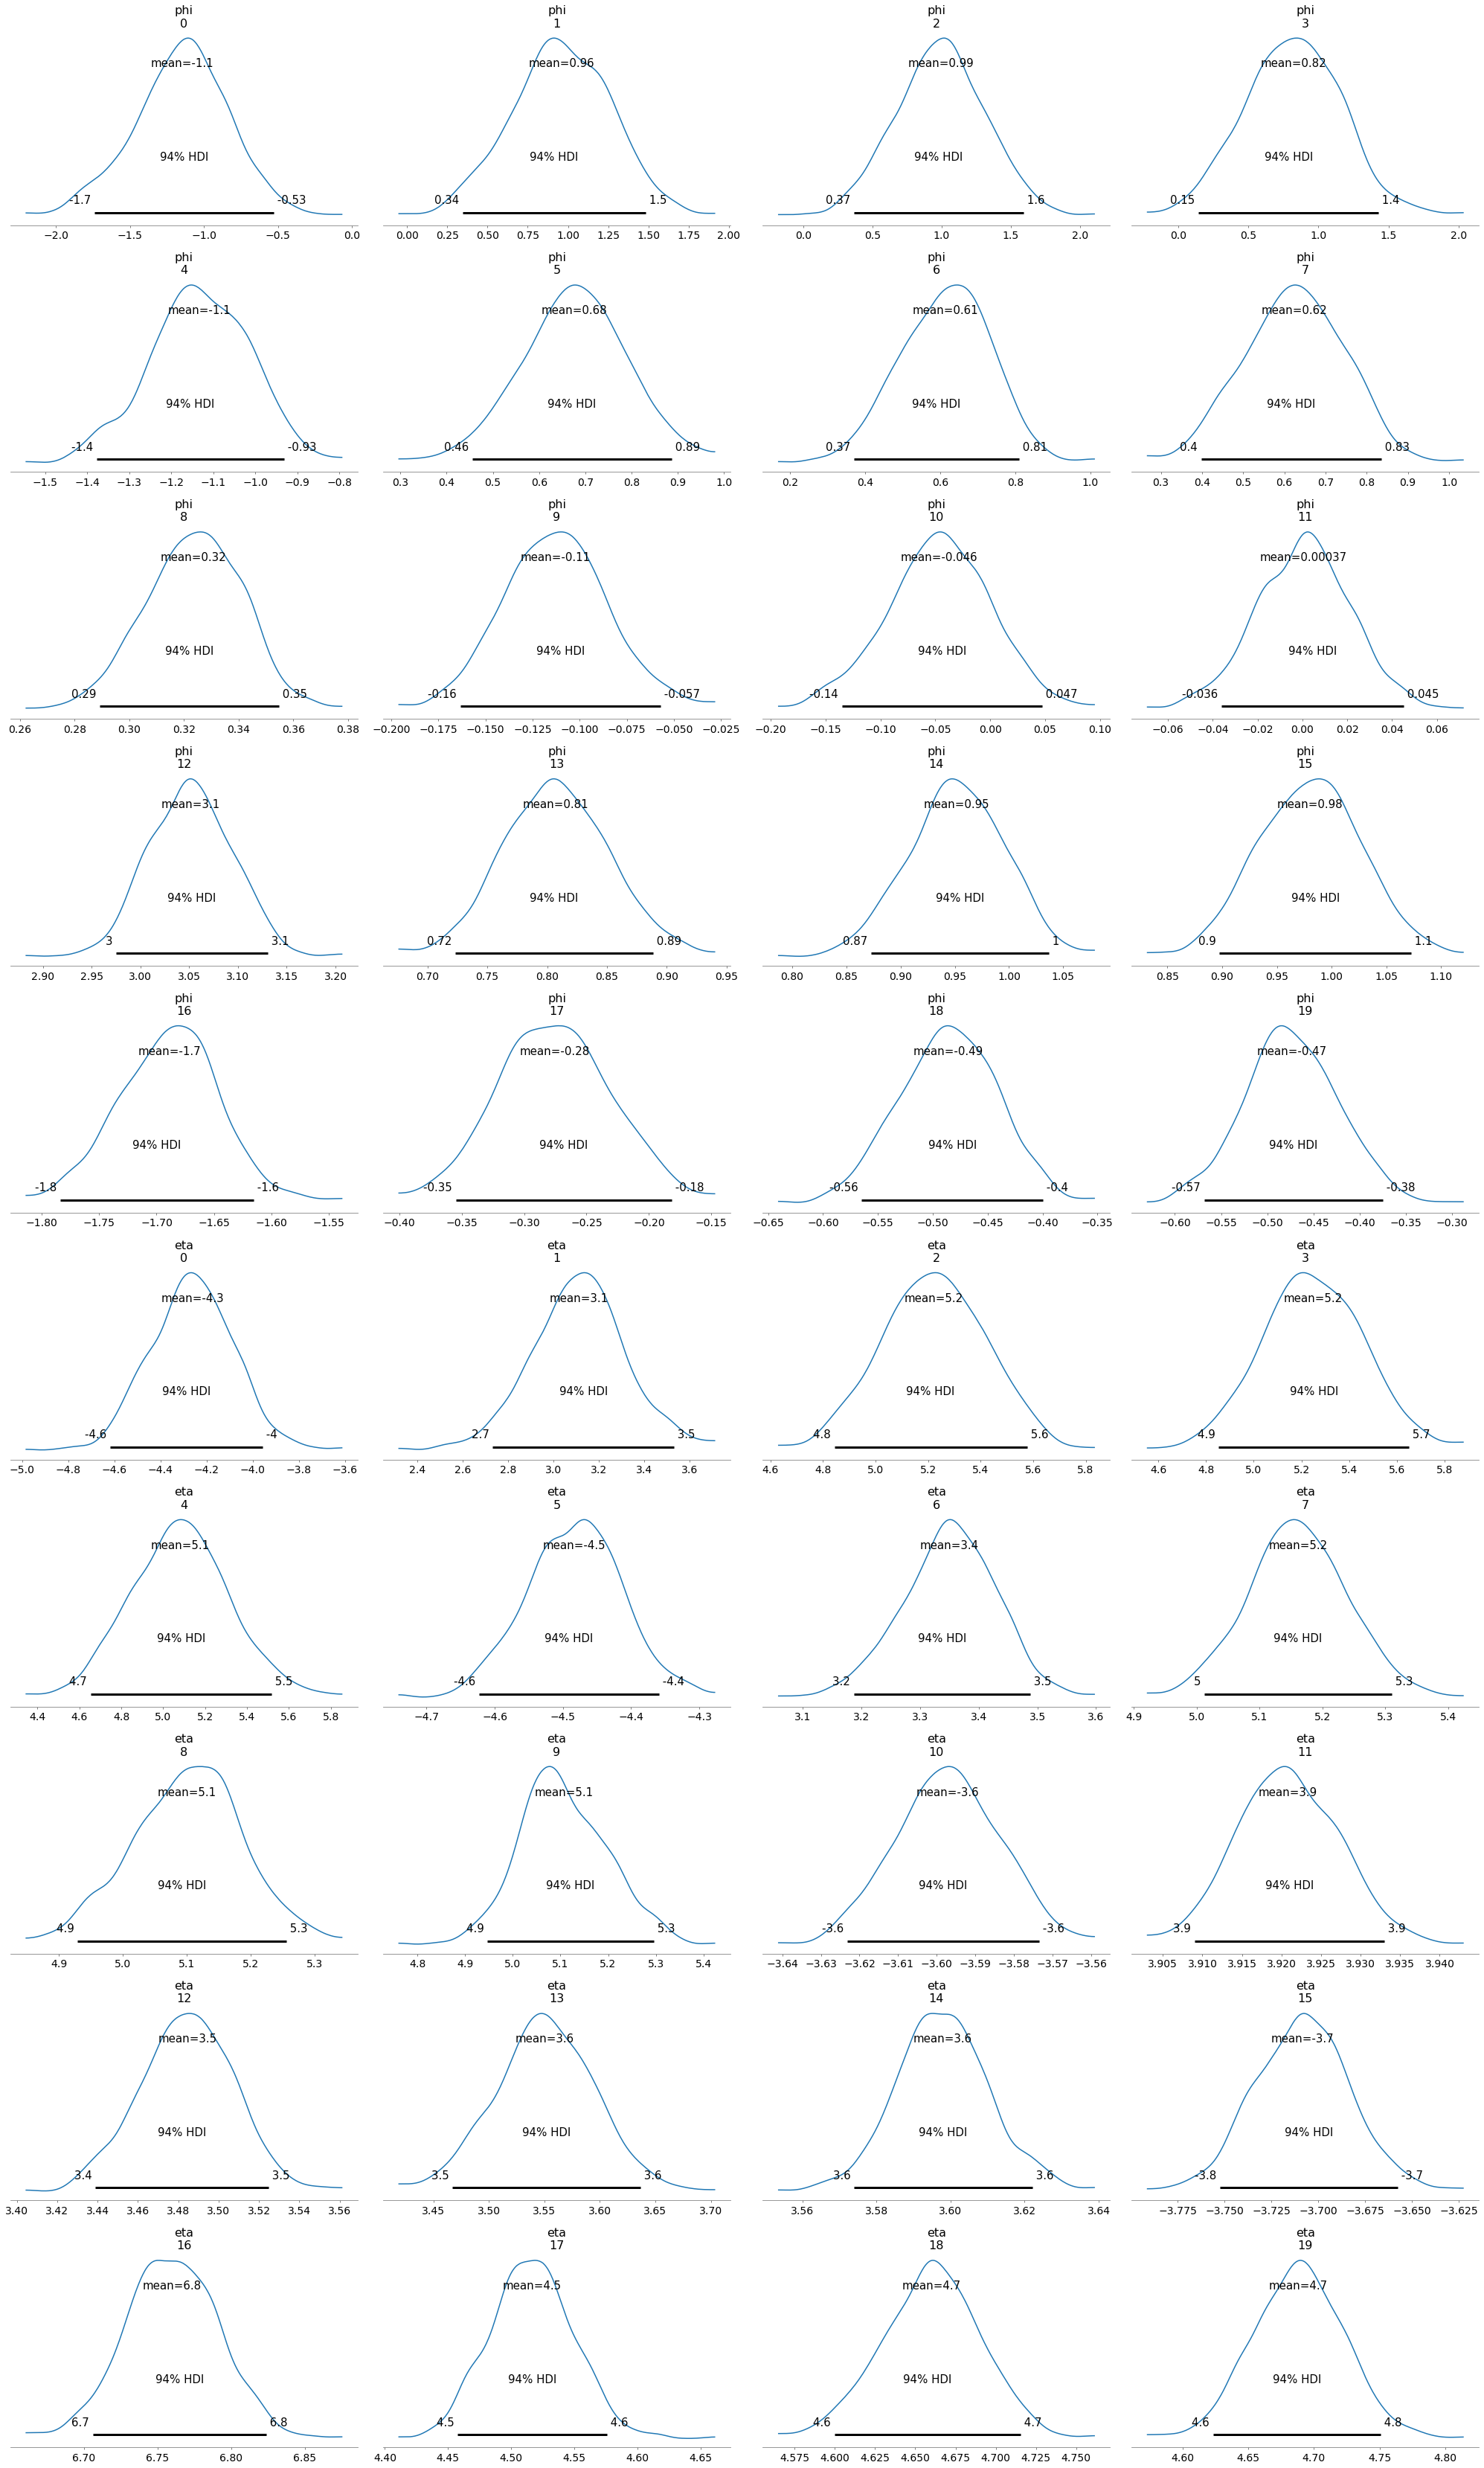

In [120]:

az.plot_posterior(svi_az)
plt.show()

---

Posterior predictive checks

In [41]:
y_train = np.array(y_train)
uniq = np.unique(y_train).astype(int)
cum_density = []
densities = []

for i in uniq:
    density = (y_train <= i).mean()
    cum_density.append((i, density))
    densities.append((i, (y_train == i).mean()))
    
cum_density = np.array(cum_density)
densities = np.array(densities)

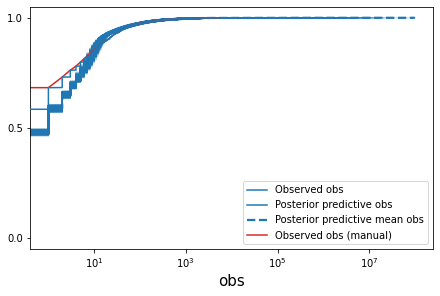

In [43]:
az.plot_ppc(svi_az, kind='cumulative')
plt.xscale('log')
plt.plot(cum_density[:,0], cum_density[:,1], c='tab:red', label='Observed obs (manual)')
# plt.yscale('log')
#plt.xlim(0, 400)
#plt.ylim(0, 0.05)
plt.set_cmap('jet')
plt.legend(loc="lower right")
plt.show()

- Max value

In [44]:
np.max(y_train)

5616.0

In [45]:
np.max(svi_samples['obs'])

99495239.0

In [46]:
np.mean(y_train)

18.135454247294195

In [47]:
np.mean(svi_samples['obs'])

42.58817343391276

In [68]:
np.percentile(y_train, 80)

6.0

In [69]:
np.percentile(svi_samples['obs'], 90)

14.0

In [48]:
np.min(y_train)

0.0

In [49]:
np.min(svi_samples['obs'])

0.0

In [50]:
maxes = np.max(svi_samples['obs'].reshape(1000,-1), axis=1)

In [51]:
np.sum(maxes > np.max(y_train))

997

In [52]:
np.log(np.max(y_train))

8.633374945705647

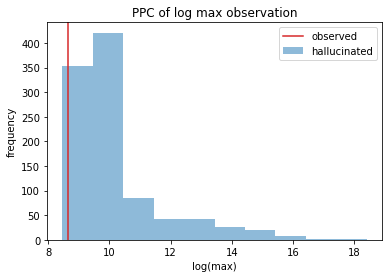

In [53]:
plt.hist(np.log(maxes), alpha=0.5, label="hallucinated")
plt.axvline(np.log(np.max(y_train)), color="tab:red", label="observed")
plt.title("PPC of log max observation")
plt.xlabel("log(max)")
plt.ylabel("frequency")
plt.legend()
plt.show()

- % obs that are 0

In [54]:
(y_train == 0).mean()

0.584191538209249

In [55]:
(svi_samples['obs'] == 0).mean()

0.48006612003935717

- % obs that are less than 10

In [56]:
(y_train < 10).mean()

0.8467694326008527

In [57]:
(svi_samples['obs'] < 10).mean()

0.8398387668087898

- % obs that are above 1k

In [58]:
(y_train > 1000).mean()

0.00321416857986225

In [59]:
(svi_samples['obs'] > 1000).mean()

0.00348586421777632

# Why Pareto?
Our distribution of total comments follows a power law.

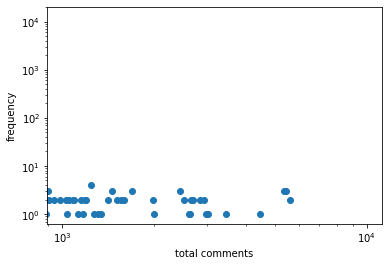

In [46]:
max_ct = np.max(y)
unique, counts = np.unique(y, return_counts=True)
plt.scatter(unique, counts)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("total comments")
plt.ylabel("frequency")
plt.show()

Fake news: expect relatively flatter (more with lots, fewer with few!)

Reviews: expect steeper (fewer comments very common)

Note that our first hour comments are also distributed similarly.

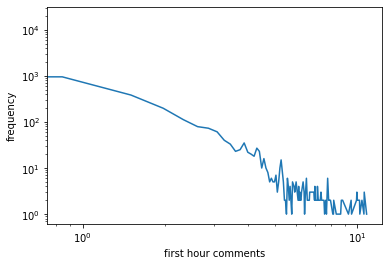

In [48]:
max_ct = np.max(p_data[:,1])
unique, counts = np.unique(p_data[:,1], return_counts=True)
plt.plot(unique, counts)
plt.yscale("log")
plt.xscale("log")
#plt.xlim(1, 10000)
plt.xlabel("first hour comments")
plt.ylabel("frequency")
plt.show()

In [ ]:
p_data[:,1].shape